The aim of this is to compare the variance of estimators of the gradient of our variational objective. This amounts to training a network for 10 and 100 epochs and comparing the variance of gradients with respect to weights in the top and bottom of the network.

Unfortunately, I've not used a network of the correct shape (it should have another hidden layer). It would be easy to fix the code, but it takes a very long time to run the network with separate weight samples. It's probably worthwhile to get results for this immediately, as the network architecture shouldn't make much difference.

In [1]:
import varout.layers
import varout.objectives
import varout.experiments
import lasagne.layers
import lasagne.nonlinearities
import theano.tensor as T
import holonets
import holoviews as hv
%load_ext holoviews.ipython

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K40c (CNMeM is disabled)


In [2]:
dataset = varout.experiments.load_data()

In [30]:
batch_size, input_dim, output_dim = 128, 784, 10
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_drop1 = varout.layers.VariationalDropoutA(l_in, p=0.2)
l_hidden = lasagne.layers.DenseLayer(l_drop1, num_units=400, nonlinearity=lasagne.nonlinearities.rectify)
l_drop2 = varout.layers.VariationalDropoutA(l_hidden, p=0.49)
l_out = lasagne.layers.DenseLayer(l_drop2, num_units=output_dim,
                                  nonlinearity=lasagne.nonlinearities.softmax)

In [31]:
def set_up_experiment(l_out, dataset, squash_updates=False):
    expressions = holonets.monitor.Expressions(l_out, dataset, update_rule=lasagne.updates.adam,
                                              loss_function=varout.objectives.mclog_likelihood(N=50000),
                                              loss_aggregate=T.mean, #extra_loss=-varout.objectives.priorKL(l_out),
                                              learning_rate=0.001)
    for c in holonets.monitor.classification_channels(expressions):
        expressions.add_channel(**c)
    expressions.add_channel(name="Bottom Weight Gradient Variance",
                            dimension="Gradient Variance",
                            expression=T.var(T.grad(expressions.loss_train,l_hidden.W)),
                            function="train")
    expressions.add_channel(name="Top Weight Gradient Variance",
                            dimension="Gradient Variance",
                            expression=T.var(T.grad(expressions.loss_train,l_out.W)),
                            function="train")
    if squash_updates:
        expressions.updates = {}
    channels = expressions.build_channels()
    train = holonets.train.Train(channels, n_batches={'train': 50000/batch_size,
                                                      'valid': 10000/batch_size})
    loop = holonets.run.EpochLoop(train, dimensions=train.dimensions)
    return loop

In [32]:
loop = set_up_experiment(l_out, dataset)

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
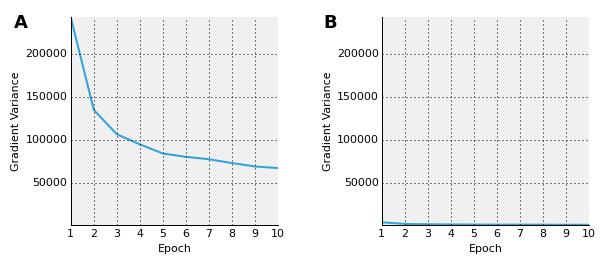

In [36]:
localA10 = loop.run(10)
localA10['Top Weight Gradient Variance'] + localA10['Bottom Weight Gradient Variance']

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
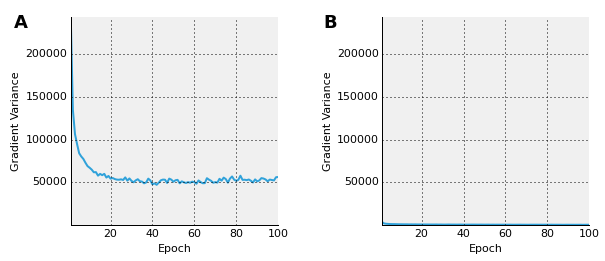

In [35]:
localA100 = loop.run(90)
localA100['Top Weight Gradient Variance'] + localA100['Bottom Weight Gradient Variance']

In [37]:
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_hidden = lasagne.layers.DenseLayer(l_in, num_units=400, nonlinearity=lasagne.nonlinearities.rectify)
l_out = lasagne.layers.DenseLayer(l_hidden, num_units=output_dim,
                                  nonlinearity=lasagne.nonlinearities.softmax)

In [38]:
loop = set_up_experiment(l_out, dataset)

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
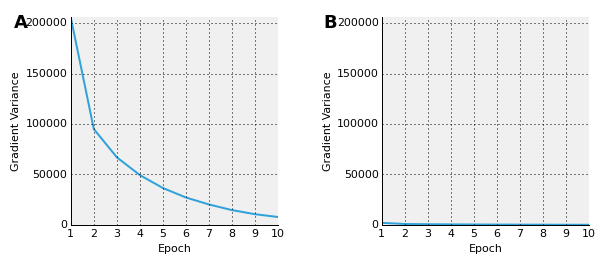

In [40]:
no_dropout10 = loop.run(10)
no_dropout10['Top Weight Gradient Variance'] + no_dropout10['Bottom Weight Gradient Variance']

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
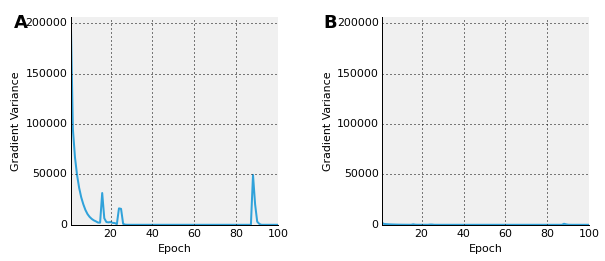

In [41]:
no_dropout100 = loop.run(90)
no_dropout100['Top Weight Gradient Variance'] + no_dropout100['Bottom Weight Gradient Variance']

In [45]:
reload(varout.layers)

<module 'varout.layers' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/variational-dropout/varout/layers.py'>

In [48]:
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_hidden = varout.layers.SingleWeightSample(l_in, num_units=400, p=0.2, nonlinearity=lasagne.nonlinearities.rectify)
l_out = varout.layers.SingleWeightSample(l_hidden, num_units=output_dim, p=0.5,
                                  nonlinearity=lasagne.nonlinearities.softmax)

In [49]:
loop = set_up_experiment(l_out, dataset)

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
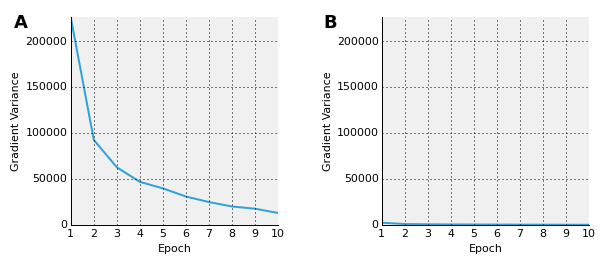

In [51]:
singlesample10 = loop.run(10)
singlesample10['Top Weight Gradient Variance'] + singlesample10['Bottom Weight Gradient Variance']

:Layout
   .Curve.I  :Curve   [Epoch]   (Gradient Variance)
   .Curve.II :Curve   [Epoch]   (Gradient Variance)
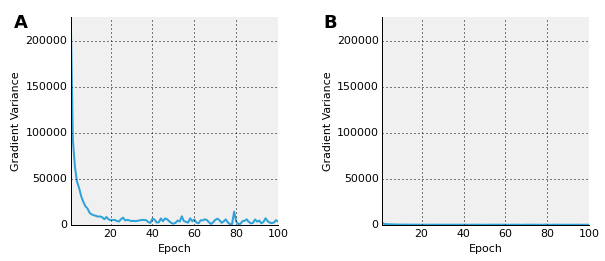

In [52]:
singlesample100 = loop.run(90)
singlesample100['Top Weight Gradient Variance'] + singlesample100['Bottom Weight Gradient Variance']

Have to load the separate weight sample networks from pickle files (because they take forever to train). Then, have to run them for a single epoch without updates to get a reading of the variance of the gradients.

In [55]:
import pickle, gzip

In [62]:
ls

Comparing Empirical Variance.ipynb  separate70results.pkl.gz
Opening Results.ipynb               t10k-images-idx3-ubyte.gz
Separate Weights.ipynb              t10k-labels-idx1-ubyte.gz
Testing layers.ipynb                train-images-idx3-ubyte.gz
results_separate_samples.pkl.gz     train-labels-idx1-ubyte.gz
separate70net.pkl.gz                trained_separate_samples.pkl.gz


In [63]:
with gzip.open("trained_separate_samples.pkl.gz", "rb") as f:
    l_in, l_hidden, l_out = pickle.load(f)

In [64]:
loop = set_up_experiment(l_out, dataset, squash_updates=True)

In [65]:
loop.run(1)
# no point in graphing single point
separate10results = loop.results

In [56]:
with gzip.open("separate70net.pkl.gz", "rb") as f:
    l_in, l_hidden, l_out = pickle.load(f)

In [58]:
loop = set_up_experiment(l_out, dataset, squash_updates=True)

INFO (theano.gof.compilelock): Refreshing lock /afs/inf.ed.ac.uk/user/s08/s0805516/.theano/stonesoup0/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.6-Carbon-x86_64-2.7.9-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /afs/inf.ed.ac.uk/user/s08/s0805516/.theano/stonesoup0/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.6-Carbon-x86_64-2.7.9-64/lock_dir/lock
/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/cmodule.py:324: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [59]:
loop.run(1)
# no point in graphing a single point
separate70results = loop.results

Building a table of comparisons:

In [70]:
type(localA10['Bottom Weight Gradient Variance'])

holoviews.element.chart.Curve

In [76]:
def get_variances(results):
    if isinstance(results['Bottom Weight Gradient Variance'], hv.element.chart.Curve):
        bottom = results['Bottom Weight Gradient Variance'].data[-1,1]
    else:
        bottom = results['Bottom Weight Gradient Variance'][-1][1]
    if isinstance(results['Top Weight Gradient Variance'], hv.element.chart.Curve):
        top = results['Top Weight Gradient Variance'].data[-1,1]
    else:
        top = results['Top Weight Gradient Variance'][-1][1]
    return top, bottom

In [92]:
print " stochastic gradient estimator      | top       | bottom"
print "------------------------------------|-----------|-------"
print "local reparameterization 10 epochs  | {:.2}   | {:.2}".format(*get_variances(localA10))
print "local reparameterization 100 epochs | {:.2}   | {:.2}".format(*get_variances(localA100))
print "separate weight samples  10 epochs  | {:.2}   | {:.2}".format(*get_variances(separate10results))
print "separate weight samples 70 epochs   | {:.2}   | {:.2}".format(*get_variances(separate70results))
print "single weight sample 10 epochs      | {:.2}   | {:.2}".format(*get_variances(singlesample10))
print "single weight sample 100 epochs     | {:.2}   | {:.2}".format(*get_variances(singlesample100))
print "no dropout 10 epochs                | {:.2}   | {:.2}".format(*get_variances(no_dropout10))
print "no dropout 100 epochs               | {:.2e} | {:.2e}".format(*get_variances(no_dropout100))

 stochastic gradient estimator      | top       | bottom
------------------------------------|-----------|-------
local reparameterization 10 epochs  | 6.7e+04   | 1.2e+03
local reparameterization 100 epochs | 5.6e+04   | 6.8e+02
separate weight samples  10 epochs  | 1.7e+04   | 3e+02
separate weight samples 70 epochs   | 3.3e+03   | 5.7e+01
single weight sample 10 epochs      | 1.3e+04   | 2.2e+02
single weight sample 100 epochs     | 3.3e+03   | 5.5e+01
no dropout 10 epochs                | 7.8e+03   | 1.1e+02
no dropout 100 epochs               | 1.08e-02 | 2.71e-04


Unfortunately, looks like we're getting greater variance for the local reparameterization at the moment, so the implementation is probably wrong.